# Evaluating Pre-trained ResNet50V2 for Plant Disease Classification

**Author:** Kristi Flowers  
**GitHub:** [github.com/KRFlowers](https://github.com/KRFlowers)  
**Date:** December 2025

 This project evaluates the effectiveness of transfer learning for multi-class image classification using convolutional neural networks. The ResNet50V2 architecture pretrained on ImageNet is implemented and compared against custom CNN baselines. The goal is to quantify how much pretrained models improve image classification performance relative to traditional CNN architectures.

### **Dataset**

 The full New Plant Diseases dataset contains approximately 87,000 RGB images of healthy and diseased crop leaves across 38 classes. To reduce training time and computational cost, this project focuses on the tomato plant subset with approximately 22,000 images spanning 10 disease classes.

Dataset source:  https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset


### **Key Results**

 - **Baseline CNN:** ~10% validation accuracy (near random performance for 10 classes)
 - **Improved CNN Architecture:** ~88% validation accuracy after architectural and regularization improvements
- **ResNet50V2 (Transfer Learning):** ~ 93% validation accuracy using frozen ImageNet weights (~95% after Bayesian hyperparameter tuning)

 **Key takeaway:**  Transfer learning with **ResNet50V2** produced the largest performance gains relative to the baseline model. While the improved CNN architecture significantly increased accuracy, it required substantially more manual configuration and tuning.

### **Technical Approach**

Three CNN architectures were developed and compared:

 1. **Minimal Baseline CNN:** A single convolutional layer to establish lower bound performance
 2. **Improved CNN Architecture:** Multiple convolutional layers with additional tuning to improve feature learning
 3. **ResNet50V2 Transfer Learning:** Pretrained ImageNet weights with a frozen convolutional base and a custom classification head.

### **Technologies Used**

> **Deep Learning:** TensorFlow 2.x, Keras API, Keras Applications (ResNet50V2)  
**Data Pipeline:** `image_dataset_from_directory`, `preprocess_input`, dataset caching and prefetching (`tf.data.AUTOTUNE`)  
**Hyperparameter Optimization:** KerasTuner (BayesianOptimization)


### **Limitations & Considerations**

- Validation data was used for model evaluation as the test set contained only 15 images with uneven class distribution.  
- Results should be interpreted as comparative performance evaluation, not production-ready metrics.

## Runtime
- ~2 hours total
- This notebook used Google Colab w/GPU 
- Hyperparameter tuning: ~90 minutes


## 1. Configure Environment

### 1.1 Install Packages (Google Colab)
Keras Tuner is required for this notebook and may need to be installed if using Colab. Skip this cell if running locally with requirements.txt.

In [ ]:
!pip install -q keras-tuner
print("Packages installed")

### 1.2 Import Libraries

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

# Core TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras

# Model architecture components
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D,
    Flatten, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.optimizers import Adam


# Pre-trained models and data loading
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory

# Hyperparameter tuning
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization

# metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)

In [42]:
# Verify TensorFlow and GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1.3 Set Configuration Options

In [ ]:
# Display settings for DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Visualization settings
sns.set_palette('husl')
%matplotlib inline

# Random seeds for reproducibility (CRITICAL for ML)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Configuration options set")
print(f"  Random seed: {RANDOM_STATE} (ensures reproducible results)")

### 1.4 Define Helper Functions

In [43]:
def display_sample_predictions(dataset, model, class_names, n=9):
    """Display sample images with predicted and actual labels."""
    for images, labels in dataset.take(1):
        predictions = model.predict(images, verbose=0)

        plt.figure(figsize=(6, 6))
        for i in range(min(n, len(images))):
            plt.subplot(3, 3, i+1)
            plt.imshow(tf.cast(images[i], tf.uint8).numpy())

            predicted_class = class_names[np.argmax(predictions[i])]
            actual_class = class_names[labels[i]]

            # Color code: green if correct, red if wrong
            color = 'green' if predicted_class == actual_class else 'red'
            plt.title(f"Predicted: {predicted_class}\nActual: {actual_class}",
                      fontsize=7, color=color)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

In [44]:
# Helper function to count images per class
def count_classes(directory):
    """Count number of images in each class folder."""
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts

In [45]:
def plot_learning_curves(history, model_name):

    history_df = pd.DataFrame(history.history)

    # Accuracy plot
    ax1 = history_df[['accuracy', 'val_accuracy']].plot(figsize=(5,3))
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_title(f'{model_name}: Training and Validation Accuracy')
    ax1.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.tight_layout()
    plt.show()

    # Loss plot
    ax2 = history_df[['loss', 'val_loss']].plot(figsize=(5,3))
    ax2.set_ylim([0, 3])
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_title(f'{model_name}: Training and Validation Loss')
    ax2.legend(['Training Loss', 'Validation Loss'])
    plt.tight_layout()
    plt.show()

## 2. Load Data
Load the dataset from Google Drive.

### 2.1 Connect to Google Drive

In [7]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.2 Verify Dataset Structure

In [8]:
# Check (visually verify) that both train and valid directories exist with all 10 disease class folders in each

root_path = "/content/drive/MyDrive/ColabData/plant_diseases_tomato"

for dirpath, dirnames, filenames in os.walk(root_path):
    print(f" {dirpath}")

 /content/drive/MyDrive/ColabData/plant_diseases_tomato
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Bacterial_spot
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Early_blight
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Late_blight
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Leaf_Mold
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Septoria_leaf_spot
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Spider_mites Two-spotted_spider_mite
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Target_Spot
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___Tomato_mosaic_virus
 /content/drive/MyDrive/ColabData/plant_diseases_tomato/train/Tomato___heal

### 2.3 Copy Data to Local Storage

**Expected Runtime:** ~5-8 minutes

In [21]:
# load data from google drive to colab
!cp -r /content/drive/MyDrive/ColabData/plant_diseases_tomato /content/dataset_folder

In [22]:
# check image size - checking only 1 file, all files will be resized to 224 x 224 when loaded
file_path = '/content/dataset_folder/train/Tomato___healthy'
for file in os.listdir(file_path):
      with Image.open(os.path.join(file_path, file)) as img:
          print(f"{file}: {img.size}")
      break  # check one file

c41aefc3-843c-49c9-8c8f-15c0e1dbc507___RS_HL 9857.JPG: (256, 256)


In [23]:
train_dir = '/content/dataset_folder/plant_diseases_tomato/train'
valid_dir = '/content/dataset_folder/plant_diseases_tomato/valid'

**NOTE - Data Integrity Check:**


It is important to verify all images loaded correctly. Review the class distribution in Section 3 to check for missing files that would indicate copy failures. If datasets are unbalanced, or seem to be missing files, re-run the copy process.

### 2.4 Load Images into TensorFlow Datasets

Images will be resized to 224×224 pixels when loading to datasets. Individual pixel values will remain at 0-255 range and will be rescaled during training. Each model has specific scaling requirements.

In [24]:
# Load training and validation image datasets
# Note: Test set not used due to insufficient size (15 images) - using validation for evaluation
IMG_SIZE = 224

train_data = image_dataset_from_directory(
    directory=train_dir,
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE, IMG_SIZE)
)

valid_data = image_dataset_from_directory(
    directory=valid_dir,
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE, IMG_SIZE)
)

Found 18345 files belonging to 10 classes.
Found 4585 files belonging to 10 classes.


In [25]:
# display class names, review and verify all classes are similar across datasets
print(train_data.class_names)
print(valid_data.class_names)

# save class names and number of classes or later use in evaluation and visualization
class_names = train_data.class_names
num_classes = len(class_names)

# print number of classes and class names
print(f'Number of classes: {num_classes}')
print(f'Class names: {class_names}')

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Number of classes: 10
Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [26]:
# Configure data pipeline optimizations for faster training
AUTOTUNE = tf.data.AUTOTUNE  # let TensorFlow auto determines  buffer size

# Build optimized pipeline: Dataset > Cache > Prefetch >  GPU
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

print(f"Training batches: {len(train_data)}")
print(f"Validation batches: {len(valid_data)}")

Training batches: 574
Validation batches: 144


## 3. Explore Data

Display sample images. Verify correct loading. Analyze class distribution to check for class imbalance.

### 3.1 Display Sample Images

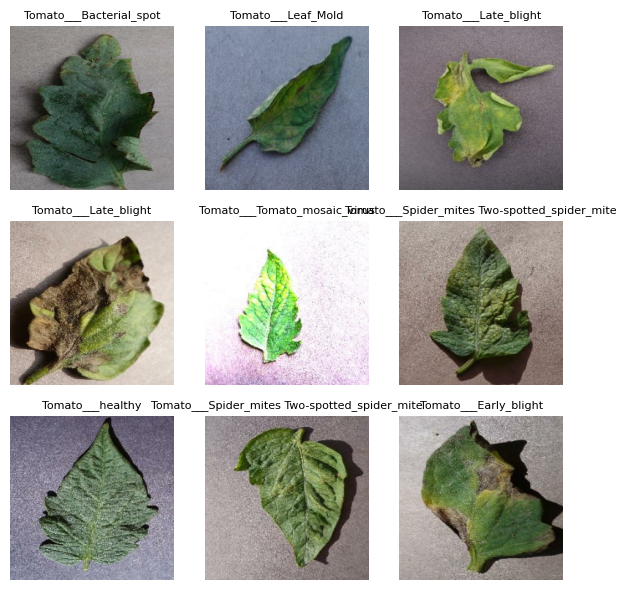

In [27]:
imgs, labels = next(iter(train_data))  # Get first 32 images

plt.figure(figsize=(6, 6))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(tf.cast(imgs[i], tf.uint8).numpy()) # Cast to uint8 for proper color display (avoids washed-out appearance)
    plt.title(class_names[int(labels[i].numpy())], fontsize=8)
    plt.axis("off")  # Remove axis numbers for cleaner display

plt.tight_layout()
plt.show()

### 3.2 Analyze Class Distributions

In [28]:
# Display TRAINING set class distribution
train_counts = count_classes(train_dir)
total_train = sum(train_counts.values())

print("TRAINING SET:")
print(f"{'Class':<50} {'Count':>10} {'Percentage':>12}")  # Changed 30 → 50

for class_name in sorted(train_counts.keys()):
    count = train_counts[class_name]
    pct = (count / total_train) * 100
    print(f"{class_name:<50} {count:>10} {pct:>11.1f}%")  # Changed 30 → 50

print(f"\nTotal: {total_train} images")

TRAINING SET:
Class                                                   Count   Percentage
Tomato___Bacterial_spot                                  1702         9.3%
Tomato___Early_blight                                    1920        10.5%
Tomato___Late_blight                                     1851        10.1%
Tomato___Leaf_Mold                                       1882        10.3%
Tomato___Septoria_leaf_spot                              1745         9.5%
Tomato___Spider_mites Two-spotted_spider_mite            1741         9.5%
Tomato___Target_Spot                                     1827        10.0%
Tomato___Tomato_Yellow_Leaf_Curl_Virus                   1961        10.7%
Tomato___Tomato_mosaic_virus                             1790         9.8%
Tomato___healthy                                         1926        10.5%

Total: 18345 images


In [29]:
# Display VALIDATION set class distribution
val_counts = count_classes(valid_dir)
total_val = sum(val_counts.values())

print("VALIDATION SET:")
print(f"{'Class':<50} {'Count':>10} {'Percentage':>12}")  # Changed 30 → 50

for class_name in sorted(val_counts.keys()):
    count = val_counts[class_name]
    pct = (count / total_val) * 100
    print(f"{class_name:<50} {count:>10} {pct:>11.1f}%")  # Changed 30 → 50

print(f"\nTotal: {total_val} images")

VALIDATION SET:
Class                                                   Count   Percentage
Tomato___Bacterial_spot                                   425         9.3%
Tomato___Early_blight                                     480        10.5%
Tomato___Late_blight                                      463        10.1%
Tomato___Leaf_Mold                                        470        10.3%
Tomato___Septoria_leaf_spot                               436         9.5%
Tomato___Spider_mites Two-spotted_spider_mite             435         9.5%
Tomato___Target_Spot                                      457        10.0%
Tomato___Tomato_Yellow_Leaf_Curl_Virus                    490        10.7%
Tomato___Tomato_mosaic_virus                              448         9.8%
Tomato___healthy                                          481        10.5%

Total: 4585 images


**Dataset Summary**:  

Classes seem to be evenly distributed across train and validation datasets.  Dataset shows no evidence of class imbalance.

## 4. Develop Models

Build 3 CNN models: minimal CNN to establish baseline performance, improved CNN with architecture tuning, and ResNet50V2 with transfer learning. Final model parameters will be optimized through Bayesian hyperparameter tuning.

### 4.1 Build Minimal Baseline CNN
Establish baseline with simple single convolutional layer.

In [33]:
# Build minimal CNN
model_baseline = Sequential()

# Input
model_baseline.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
model_baseline.add(Rescaling(1./255))

# Single convolutional layer
model_baseline.add(Conv2D(32, 3, activation='relu'))
model_baseline.add(MaxPooling2D())

model_baseline.add(Flatten())
model_baseline.add(Dense(32, activation='relu'))
model_baseline.add(Dense(num_classes, activation='softmax'))

# Compile model
model_baseline.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │    12,616,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,617,962 (48.13 MB)

 Trainable params: 12,617,962 (48.13 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# fit model
history_baseline = model_baseline.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

Epoch 1/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.1022 - loss: 3.2766 - val_accuracy: 0.1069 - val_loss: 2.3017
Epoch 2/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1065 - loss: 2.3023 - val_accuracy: 0.1069 - val_loss: 2.3016
Epoch 3/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1035 - loss: 2.3024 - val_accuracy: 0.1069 - val_loss: 2.3015
Epoch 4/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1005 - loss: 2.3025 - val_accuracy: 0.1069 - val_loss: 2.3016
Epoch 5/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1014 - loss: 2.3025 - val_accuracy: 0.1069 - val_loss: 2.3016
Epoch 6/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1012 - loss: 2.3025 - val_accuracy: 0.1069 - val_loss: 2.3016
Epoch 7/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1012 - loss: 2.3025 - val_accuracy: 0.1069 - val_loss: 2.3016
Epoch 8/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.1012 - loss: 2.3025 - 

In [35]:
model_baseline.evaluate(valid_data)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1058 - loss: 2.3022


[2.301560878753662, 0.10687022656202316]

**Baseline Results:**

The simple CNN achieved only ~10% validation accuracy. This demonstrates that the simple architecture needs tuning to achieve adequate performance.

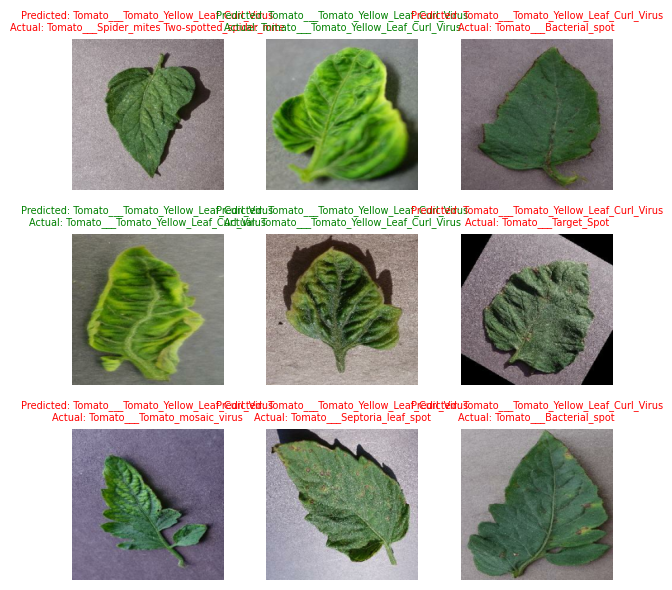

In [36]:
# show some predictions
display_sample_predictions(valid_data, model_baseline, class_names)

**Prediction Analysis:**

The sample predictions show predominantly incorrect classifications (red labels). The model is frequently confusing visually similar disease types. This visual evidence confirms the performance results that a single convolutional layer cannot learn the complex features needed to classify between different disease patterns.

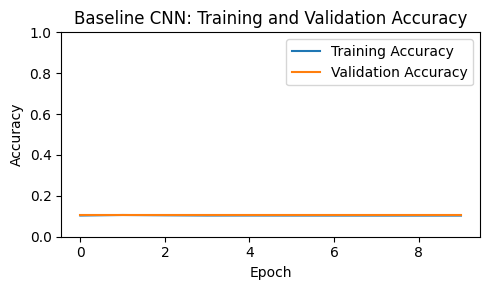

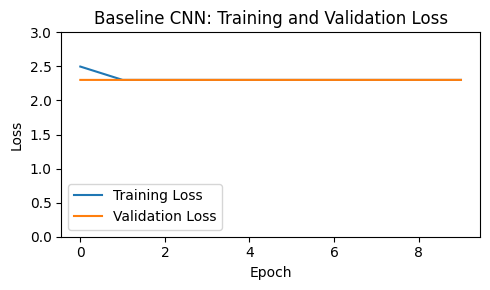

In [39]:
# Plot learning curves
plot_learning_curves(history_baseline, 'Baseline CNN')

**Learning Curves Analysis (Base Model):**

 The flat curves (both training and validation at ~10%) demonstrate the model does not have enough parameters and depth to learn complex visual patterns. Hyperparameter tuning cannot fix this architectural limitation and a deeper model with additional convolutional layers is required.


### 4.2 Build Improved CNN Architecture

Build a deeper CNN model to fix the performance issues from Section 4.1. Increase parameters through additional layers and add regularization and dropout.

**~10 minutes**

In [46]:

model_cnn = Sequential()

# Input and preprocessing
model_cnn.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
model_cnn.add(Rescaling(1./255))

# Add layers
model_cnn.add(Conv2D(32, 3, activation='relu'))
model_cnn.add(MaxPooling2D())
model_cnn.add(Conv2D(64, 3, activation='relu'))
model_cnn.add(MaxPooling2D())

# Add regularization
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(num_classes, activation='softmax'))

# Compile model
model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,682 (91.20 MB)

 Trainable params: 23,908,682 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Train improved CNN model
history_cnn = model_cnn.fit(
    train_data,
    validation_data=valid_data,
    epochs=10
)

Epoch 1/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.4914 - loss: 1.7146 - val_accuracy: 0.8242 - val_loss: 0.5055
Epoch 2/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8102 - loss: 0.5555 - val_accuracy: 0.8585 - val_loss: 0.4264
Epoch 3/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.8721 - loss: 0.3867 - val_accuracy: 0.8495 - val_loss: 0.4492
Epoch 4/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9014 - loss: 0.2908 - val_accuracy: 0.9036 - val_loss: 0.2942
Epoch 5/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9356 - loss: 0.1987 - val_accuracy: 0.9010 - val_loss: 0.2991
Epoch 6/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9472 - loss: 0.1634 - val_accuracy: 0.8981 - val_loss: 0.3308
Epoch 7/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9556 - loss: 0.1319 - val_accuracy: 0.9073 - val_loss: 0.3295
Epoch 8/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.9610 - loss: 0.1105 - 

In [48]:
# Evaluate on validation set
model_cnn.evaluate(valid_data)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8884 - loss: 0.4123


[0.4296499192714691, 0.8902944326400757]

**Improved CNN Results:**

Two-layer CNN achieved 88% validation accuracy.  This demonstrates that proper architectural design significantly improves performance over the minimal baseline (10-15% to 88%). This represents a 60-75 percentage point improvement through model improvements alone.

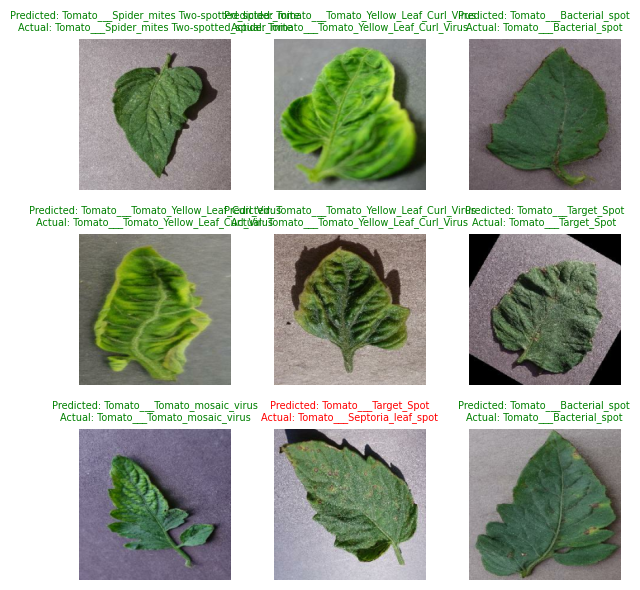

In [49]:
# Display sample predictions
display_sample_predictions(valid_data, model_cnn, class_names)

**Prediction Analysis:**

The sample predictions show predominprimarily correct classifications (green labels).

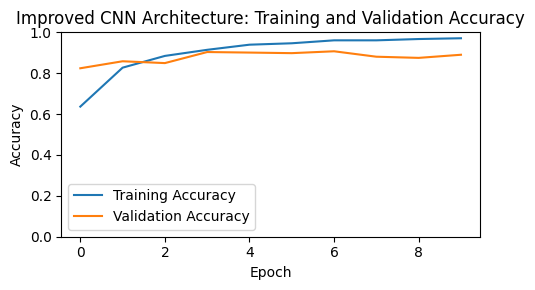

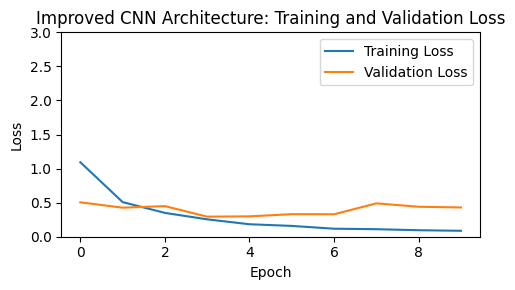

In [50]:
# Plot learning curves
plot_learning_curves(history_cnn, 'Improved CNN Architecture')

**Learning Curves Analysis:**

The model shows strong learning with validation accuracy reaching 88% and maintaining stable performance. While some gap between training and validation suggests mild overfitting, the improved architecture demonstrates adequate capacity for this classification task. Transfer learning will be evaluated next to see if pretrained features can improve further.


### 4.3 Build ResNet50V2 with Transfer Learning

Apply transfer learning to assess whether pretrained ImageNet features can improve beyond custom CNN. Use frozen ResNet50V2 base layers with custom classification head. Data will be reloaded with ResNet-specific preprocessing.

**Expected Runtime:** ~15 minutes

**ResNet-Specific Preprocessing Required:**

ResNet50V2 requires model-specific preprocessing (`preprocess_input`) that differs from the 0-1 rescaling used by baseline/improved CNNs. This preprocessing converts RGB / BGR color channel order and centers pixel values around ImageNet mean. Data must be reloaded with this preprocessing applied  to ensure pretrained weights function correctly.

In [52]:
# Load data with ResNet-specific preprocessing
train_data_resnet = image_dataset_from_directory(
    directory=train_dir,
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE, IMG_SIZE)
)

valid_data_resnet = image_dataset_from_directory(
    directory=valid_dir,
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE, IMG_SIZE)
)

# Apply ResNet preprocessing (RGB/BGR conversion, ImageNet mean centering)
train_data_resnet = train_data_resnet.map(lambda x, y: (preprocess_input(x), y))
valid_data_resnet = valid_data_resnet.map(lambda x, y: (preprocess_input(x), y))

# Optimize with caching and prefetching, must follow preprocessing
AUTOTUNE = tf.data.AUTOTUNE
train_data_resnet = train_data_resnet.cache().prefetch(buffer_size=AUTOTUNE)
valid_data_resnet = valid_data_resnet.cache().prefetch(buffer_size=AUTOTUNE)

Found 18345 files belonging to 10 classes.
Found 4585 files belonging to 10 classes.


In [53]:
# Build pre-trained ResNet50V2 without top layer
resnet_base = ResNet50V2(
    include_top=False,              # Remove original classification layers
    weights='imagenet',              # Load pre-trained ImageNet weights
    input_shape=(224, 224, 3)
)
# Freeze base resnet model
resnet_base.trainable = False

# Build custom classification head on top of frozen ResNet base
model_resnet = Sequential()
model_resnet.add(resnet_base)                              # Frozen feature extractor
model_resnet.add(GlobalAveragePooling2D())                 # Spatial averaging (ResNet standard)
model_resnet.add(Dense(num_classes, activation='softmax')) # 10-class output

# Compile model
model_resnet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [54]:
model_resnet.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [55]:
# Train model (use ResNet-preprocessed data)
history_resnet = model_resnet.fit(
    train_data_resnet,  # ← Use the ResNet-specific preprocessed data
    validation_data=valid_data_resnet,  # ← Use the ResNet-specific preprocessed data
    epochs=10
)

Epoch 1/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 73s 108ms/step - accuracy: 0.6722 - loss: 1.0112 - val_accuracy: 0.8724 - val_loss: 0.4059
Epoch 2/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.8987 - loss: 0.3443 - val_accuracy: 0.8971 - val_loss: 0.3172
Epoch 3/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.9290 - loss: 0.2515 - val_accuracy: 0.9067 - val_loss: 0.2786
Epoch 4/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.9442 - loss: 0.2009 - val_accuracy: 0.9145 - val_loss: 0.2569
Epoch 5/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.9550 - loss: 0.1675 - val_accuracy: 0.9202 - val_loss: 0.2428
Epoch 6/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.9636 - loss: 0.1433 - val_accuracy: 0.9234 - val_loss: 0.2330
Epoch 7/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.9698 - loss: 0.1247 - val_accuracy: 0.9274 - val_loss: 0.2255
Epoch 8/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.9745 - loss: 0.1097 -

In [56]:
model_resnet.evaluate(valid_data_resnet)


144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9335 - loss: 0.2111


[0.212859645485878, 0.9343511462211609]

**Transfer Learning Results:**

ResNet50V2 achieved 93.4% validation accuracy, a further improvement over the improved CNN (88% → 93.4%). This shows pretrained ImageNet features can provide strong performance even with minimal configuration.

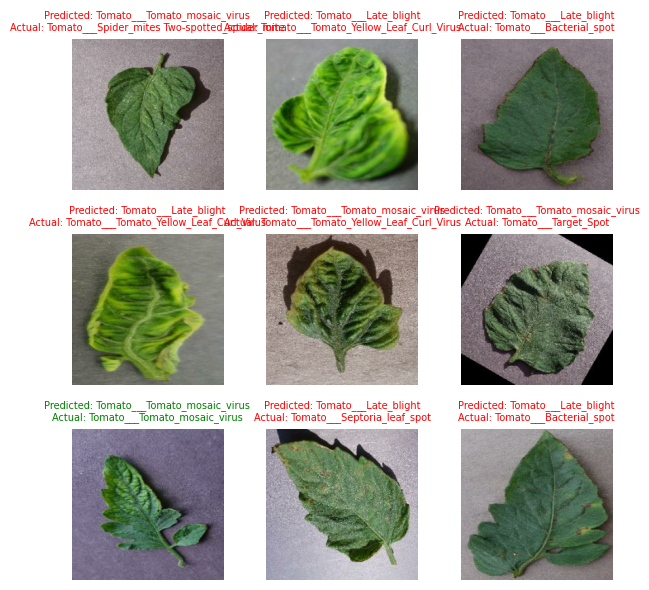

In [68]:
display_sample_predictions(valid_data, model_resnet, class_names)

**Prediction Analysis:**

The sample predictions appear inconsistent with the 93.4% validation accuracy and most likely are due to preprocessing. However, the accuracy evaluation (93.4% ) and learning curves both confirm strong model performance. The metrics are reliable and it appears the visualization has technical limitations.

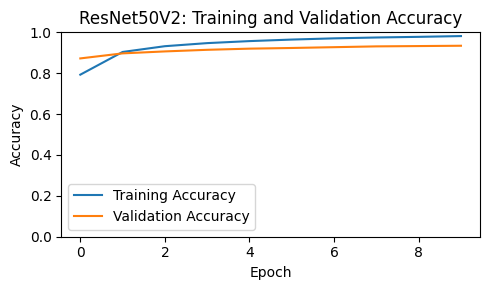

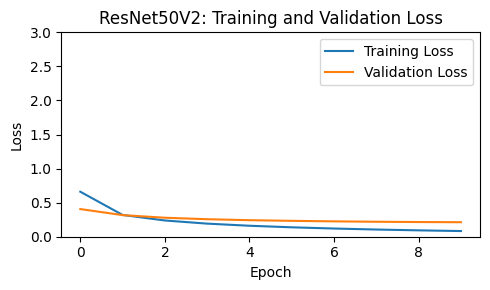

In [70]:
# Plot learning curves
plot_learning_curves(history_resnet, 'ResNet50V2')

**Learning Curves Analysis (ResNet50V2):**

The model shows fast convergence starting from 80% (benefiting from pretrained weights) and reaching 93.4% by epoch 10. The small gap between training (95%) and validation (93%) indicates minimal overfitting. Transfer learning with frozen pretrained features appears to provide both strong performance and good generalization. Next, Keras Tuner will be used to optimize hyperparameters for potential further improvement.

#### 4.3.1 Apply Hyperparameter Optimization
Apply hyperparameter seach with Bayesian Optimization to the ResNet architecture to determine whether tuning would provide meaningful gains (> 93%).

**Parameters Tuned:**
- Dropout rate (0.0-0.5) for regularization
- Dense layer units (0-128) for optional hidden layer
- Learning rate (1e-5 to 3e-4) for optimization
- ResNet base is frozen throughout

**Keras Tuner Setup:**
- Bayesian Optimization option. This is probabilistic (more efficient than random/grid)
- 12 trials, 10 epochs each

**Expected Runtime:** ~90 minutes

In [71]:
# Build tunable model with hyperparameters using  Keras Tuner
def build_model(hp):

  # Load frozen ResNet50V2 base (same as Section 4.3)
  base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
  base_model.trainable = False

  # Define tunable hyperparameters with search ranges
  drop_rate = hp.Float('dropout', 0.0, 0.5, step=0.1, default=0.3)    # Regularization strength
  units = hp.Int('dense_units', 0, 128, step=32, default=0)            # Hidden layer size (0 = no hidden layer)
  lr = hp.Choice('lr', [1e-5, 3e-5, 1e-4, 3e-4], default=3e-4)        # Learning rate

  # Build model architecture
  model = Sequential()
  model.add(base_model)
  model.add(GlobalAveragePooling2D())

  # Add hidden Dense layer if units > 0
  if units > 0:
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(drop_rate))

  model.add(Dense(num_classes, activation='softmax'))

  # Compile with tunable learning rate
  model.compile(
      optimizer=keras.optimizers.Adam(lr),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [72]:
# Create Keras Tuner with Bayesian Optimization
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',          # Maximize validation accuracy
    max_trials=12,                     # 12 trials based on previous convergence
    executions_per_trial=1,
    directory='my_dir',
    project_name='resnet50v2_tuning_bayes'
)

In [73]:
# Run hyperparameter search
# This trains 12 different configurations (trials) / 10 epochs each = 120 total epochs
# ~90 minutes
tuner.search(train_data_resnet, validation_data=valid_data_resnet, epochs=10)

Trial 12 Complete [00h 07m 39s]
val_accuracy: 0.9179934859275818

Best val_accuracy So Far: 0.94547438621521
Total elapsed time: 01h 31m 49s


In [74]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best dropout:", best_hyperparameters.get('dropout'))
print("Best dense_units:", best_hyperparameters.get('dense_units'))
print("Best learning rate:", best_hyperparameters.get('lr'))

Best dropout: 0.2
Best dense_units: 128
Best learning rate: 0.0003


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Hyperparameter Search Results:**

The Keras Tuner selected the maximum dense layer capacity (128 units), moderate dropout (0.2) for regularization, and a conservative learning rate (0.0003) which makes sense for fine-tuning pretrained features. These parameters were the optimal configuration among the 12 trials evaluated.

In [75]:
# Train the best model, use ResNet-preprocessed data
history_tuned = best_model.fit(train_data_resnet, validation_data=valid_data_resnet, epochs=10)

Epoch 1/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 61s 92ms/step - accuracy: 0.9750 - loss: 0.0852 - val_accuracy: 0.9350 - val_loss: 0.1831
Epoch 2/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.9795 - loss: 0.0691 - val_accuracy: 0.9394 - val_loss: 0.1833
Epoch 3/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.9826 - loss: 0.0618 - val_accuracy: 0.9470 - val_loss: 0.1627
Epoch 4/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.9852 - loss: 0.0500 - val_accuracy: 0.9411 - val_loss: 0.1855
Epoch 5/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.9854 - loss: 0.0487 - val_accuracy: 0.9498 - val_loss: 0.1537
Epoch 6/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.9898 - loss: 0.0383 - val_accuracy: 0.9446 - val_loss: 0.1633
Epoch 7/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 44s 76ms/step - accuracy: 0.9902 - loss: 0.0362 - val_accuracy: 0.9492 - val_loss: 0.1602
Epoch 8/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - accuracy: 0.9895 - loss: 0.0345 - 

In [76]:
best_model.evaluate(valid_data_resnet)

144/144 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.9491 - loss: 0.1565


[0.16214163601398468, 0.9504907131195068]

**KerasTuner Performance Results**:

The Reset50V2 Model tuned with KerasTuner achieved 95% validation accuracy, a further +2 point improvement over the previously improved CNN (~93%).

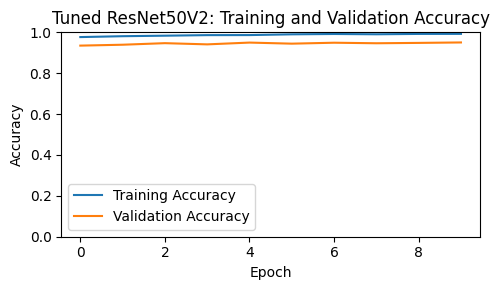

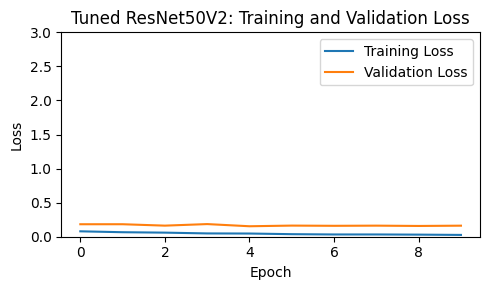

In [77]:
# Plot learning curves
plot_learning_curves(history_tuned, 'Tuned ResNet50V2')

**Learning Curves Analysis (Hyperparameter Tuning Results):**

The training curves show rapid convergence within the first epoch, with both training and validation accuracy immediately reaching ~95%. The minimal gap between training and validation metrics indicates no overfitting. The quick convergence demonstrates that the optimized hyperparameters and pre-trained ResNet features are close to peak performance for this dataset.

## 5. Evaluate Results
Compare final performance across all three models.

In [87]:
# Extract final validation accuracies from history objects
baseline_acc = history_baseline.history['val_accuracy'][-1]
cnn_acc = history_cnn.history['val_accuracy'][-1]
resnet_acc = history_resnet.history['val_accuracy'][-1]
tuned_acc = history_tuned.history['val_accuracy'][-1]

# Create comparison table
model_results = {
    'Model': ['Minimal Baseline CNN', 'Improved CNN', 'ResNet50V2 Transfer', 'ResNet50V2 Tuned'],
    'Validation Accuracy': [baseline_acc, cnn_acc, resnet_acc, tuned_acc],
    'Improvement': ['-', f'+{(cnn_acc - baseline_acc)*100:.1f} pts',
                    f'+{(resnet_acc - cnn_acc)*100:.1f} pts',
                    f'+{(tuned_acc - resnet_acc)*100:.1f} pts']
}

results_df = pd.DataFrame(model_results)
print("MODEL PERFORMANCE COMPARISON")
print("-"*80)
print(results_df.to_string(index=False))
print("="*80)

# Calculate cumulative improvements
print(f"\nArchitectural improvement (base model  → improved CNN): +{(cnn_acc - baseline_acc)*100:.1f} percentage points")
print(f"Transfer learning improvement (improved CNN → ResNet): +{(resnet_acc - cnn_acc)*100:.1f} percentage points")
print(f"Hyperparameter tuning improvement (ResNet → tuned): +{(tuned_acc - resnet_acc)*100:.1f} percentage points")
print(f"\nTotal improvement (minimal → tuned): +{(tuned_acc - baseline_acc)*100:.1f} percentage points")


MODEL PERFORMANCE COMPARISON
--------------------------------------------------------------------------------
               Model  Validation Accuracy Improvement
Minimal Baseline CNN             0.106870           -
        Improved CNN             0.890294   +78.3 pts
 ResNet50V2 Transfer             0.934351    +4.4 pts
    ResNet50V2 Tuned             0.950491    +1.6 pts

Architectural improvement (base model  → improved CNN): +78.3 percentage points
Transfer learning improvement (improved CNN → ResNet): +4.4 percentage points
Hyperparameter tuning improvement (ResNet → tuned): +1.6 percentage points

Total improvement (minimal → tuned): +84.4 percentage points


## Conclusion

**Key Findings:**
- **Transfer learning proved highly effective:** Pre-trained ResNet50V2 achieved 93.4% accuracy with minimal configuration and rapid convergence.
- A proper CNN design improved baseline performance from 10.7% to 89.0% (+78.3 percentage points)
- Hyperparameter optimization yielded modest refinements: automated tuning improved performance from 93.4% to 95.0% (+1.6 percentage points), showing diminishing returns once transfer learning is applied

**Recommendations:**
- Start with transfer learning for image classification as it clearly shows strong performance with minimal training time
- Apply hyperparameter optimization selectively due to training time versus incremental gains
- Implement data loading best practices (caching, prefetching) for large datasets

**Lessons Learned:**
- Image preprocessing can be more complex than model configuration. The model can actually require less setup than the preprocessing pipeline
- It is very important to validate file counts after transfers as image loading from remote storage can fail without warning
- Data integrity checks can serve dual purposes: verifying class balance and detecting quality issues before training

### **References**

**Dataset:**  
New Plant Diseases Dataset. Kaggle. https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

**Documentation:**  
Keras - Getting Started with KerasTuner. https://keras.io/keras_tuner/getting_started/  
Keras - Transfer Learning Guide. https://keras.io/guides/transfer_learning/  
Keras - ResNet and ResNetV2 API. https://keras.io/api/applications/resnet/  
TensorFlow - Transfer Learning Tutorial. https://www.tensorflow.org/tutorials/images/transfer_learning